<h2>Analysis for looking throgh the Interprlated data</h2>

In [33]:
import pandas as pd
import sys
sys.path.append('..')

from spyral.core.constants import QBRHO_2_P
from spyral.core.run_stacks import form_run_string

from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from spyral_utils.plot import Histogrammer

from pathlib import Path
from scipy.constants import physical_constants, torr
from scipy.stats import iqr
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import vector
import lmfit

%matplotlib widget

In [34]:
run_min = 53
run_max = 169


#df = pd.read_parquet(f"/Volumes/researchEXT/O16/O16_spyral_analysis/InterpSolver/run_00{run_number}_4He.parquet")

In [35]:
workspace_path = Path("/Volumes/personal_space/single_dv_workspace")
target_material_path = Path("/Users/pranjalsingh/Desktop/research_space_spyral/e20020_analysis/solver_gas_16O.json")
solver_result_path = workspace_path / "InterpSolver"
beam_events_path = workspace_path / "beam_events"


In [36]:
ejectile_z = 2
ejectile_a = 4

projectile_z = 8
projectile_a = 16

target_z = 2
target_a = 4

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

if residual_z < 0:
    raise Exception(f"Illegal nuclei! Residual Z: {residual_z}")
if residual_a < 1:
    raise Exception(f"Illegal nuclei! Residual A: {residual_a}")

In [37]:
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')

ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)
print(f"Reaction: {target}({projectile}, {ejectile}){residual}")
print(f"Target material: {target_material.ugly_string}")

Reaction: 4He(16O, 4He)16O
Target material: (Gas)4He1


In [38]:
# Define parameters used for finding the cross section

downscale_factor = 1000

ic_min_val = -1
ic_max_val = 1000000

boltzmann = physical_constants["Boltzmann constant"][0]    # Units of Joules / Kelvin
torr_2_pascal = torr    # Convert from torr to pascals
pressure = 700 # Units of torr
temperature = 293.15    # Units of Kelvin, room temperature
stoich = 1 # Stoichiometry of gas

In [39]:
proj_energy_start = 160  # Units of MeV. Initial beam energy

min_z = 0.004    # Units of meters. Minimum z value of vertex (inclusive)
max_z = 0.958    # Units of meters. Maximum z value of vertex (inclusive)

min_cm = 10.0    # Units of degrees. Minimum center-of-mass scattering angle for events in excitation spectrum (inclusive)
max_cm = 37.0   # Units of degrees. Maximum center-of-mass scattering angle for events in excitation spectrum (inclusive)

hist_en_min = -1.0        # Smallest allowed excitation energy in histogram (inclusive)
hist_en_max = 4.3    # Largest allowed excitation energy in histogram (inclusive)
hist_en_bins = 40        # Number of bins in excitation energy histogram

ang_dist_bins =  9 

In [40]:
states = {}
states["gs"] = {"peak_num": 1,
                "sub_min": -0.1,
                "sub_max": 0.1,
                "cent_min": -0.07,
                "cent_max": 0.08,
                "sim_workspace": Path("/Volumes/researchEXT/O16/O16_spyral_analysis"),
                "sim_parq": Path("E:\\final\\dp_gs\\dp_gs_kine.parquet"),
                "sim_run_min": 0,
                "sim_run_max": 29}

states["6.05"] = {"peak_num": 2,
                "sub_min": 0.2,
                "sub_max": 0.4,
                "cent_min": 0.2,
                "cent_max": 0.4,
                "sim_workspace": Path("E:\\final\\dp_0.32\\workspace\\InterpSolver"),
                "sim_parq": Path("E:\\final\\dp_0.32\\dp_0.32_kine.parquet"),
                "sim_run_min": 0,
                "sim_run_max": 29}


In [41]:
state2analyze = "gs"

In [42]:
results = {}

# Add keys for result parameters
results["polar"] = np.empty(0, float)
results["kinetic_energy"] = np.empty(0, float)
results["ex_energy"] = np.empty(0, float)
results["cm_polar"] = np.empty(0, float)
results["chisq"] = np.empty(0, float)
results["z_vert"] = np.empty(0, float)
results["brho"] = np.empty(0, float)

# Create histogram tool
grammer = Histogrammer()

In [43]:
target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})

for run in range(run_min, run_max+1):

    df = None
    path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"

    if not path.exists():
        continue
    
    df = pl.scan_parquet(path)

    df = (df.filter((pl.col("vertex_z") >= min_z) 
                    & (pl.col("vertex_z") <= max_z)
                    )
                .collect()
        )
    
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
            "px": np.zeros(len(projectile_ke)),
            "py": np.zeros(len(projectile_ke)),
            "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
            "E": projectile_ke + projectile.mass
        })
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
            "px": momentum * np.sin(polar) * np.cos(az),
            "py": momentum * np.sin(polar) * np.sin(az),
            "pz": momentum * np.cos(polar),
            "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
        })
        
    cs = df.select('redchisq').to_numpy().flatten()
    zvert=df.select('vertex_z').to_numpy().flatten()

    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    results["polar"] = np.append(results["polar"], polar)
    results["kinetic_energy"] = np.append(results["kinetic_energy"], kinetic_energy)
    results["ex_energy"] = np.append(results["ex_energy"], ex_energy)
    results["cm_polar"] = np.append(results["cm_polar"], cm_polar)
    results["chisq"] = np.append(results["chisq"], cs)
    results["z_vert"] = np.append(results["z_vert"], zvert)
    results["brho"] = np.append(results["brho"], brho)


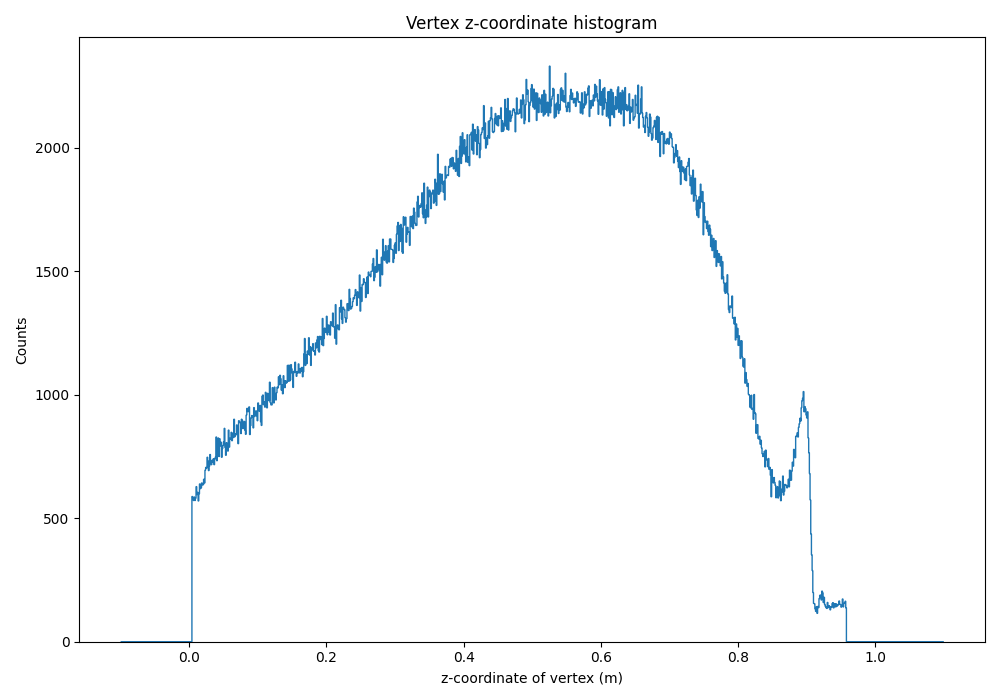

In [44]:
grammer.add_hist1d('z_vert', 1200, (-0.1, 1.1))
grammer.fill_hist1d('z_vert', results["z_vert"])
vertz = grammer.get_hist1d("z_vert")

fig, ax = plt.subplots(1,1)
ax.stairs(vertz.counts, edges=vertz.bins)
ax.set_title(f"Vertex z-coordinate histogram")
ax.set_xlabel("z-coordinate of vertex (m)")
ax.set_ylabel("Counts")
fig.set_figheight(7.0)
fig.set_figwidth(10.0)
fig.tight_layout()

In [45]:
# Calculate kinematics for residual particle in given states
proj_energy_stop = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, np.array([1.0]))[0] # Energy at far end of detector
print(f"Beam energy range: {proj_energy_start}-{proj_energy_stop} MeV")
residual_excitations = np.array([0.0,6.05])

# Do the calculation in the center of mass
cm_angle_range = np.linspace(0., np.pi, 1000)
# Calculate envelope from range of beam energies
eject_kinematics = np.zeros((len(residual_excitations), len(cm_angle_range) * 2, 2))

# Upper limit (maximum beam energy)
beam_vec_max = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_start * (proj_energy_start + 2.0 * projectile.mass))],
    "E": [proj_energy_start + projectile.mass]
})
parent_max = target_vector + beam_vec_max
parent_cm_max = parent_max.boostCM_of(parent_max)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_max = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_max.E**2.0) / (2.0 * parent_cm_max.E)
    eject_p_cm_max = np.sqrt(eject_e_cm_max**2.0 - ejectile.mass**2.0)
    eject_vec_cms_max = vector.array({
        "px": eject_p_cm_max * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_max * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_max)
    })
    eject_vec_lab_max = eject_vec_cms_max.boost(parent_max)
    eject_kinematics[idx, :len(cm_angle_range), 0] = eject_vec_lab_max.theta
    eject_kinematics[idx, :len(cm_angle_range), 1] = eject_vec_lab_max.E - ejectile.mass

# Lower limit (minimum beam energy)
beam_vec_min = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_stop * (proj_energy_stop + 2.0 * projectile.mass))],
    "E": [proj_energy_stop + projectile.mass]
})
parent_min = target_vector + beam_vec_min
parent_cm_min = parent_min.boostCM_of(parent_min)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_min = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_min.E**2.0) / (2.0 * parent_cm_min.E)
    eject_p_cm_min = np.sqrt(eject_e_cm_min**2.0 - ejectile.mass**2.0)
    eject_vec_cms_min = vector.array({
        "px": eject_p_cm_min * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_min * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_min)
    })
    eject_vec_lab_min = eject_vec_cms_min.boost(parent_min)
    # Note that lower limit is "flipped". We plot the band as a polygon, so need to continue from large lab angles to small lab angles
    eject_kinematics[idx, len(cm_angle_range):, 0] = np.flip(eject_vec_lab_min.theta)
    eject_kinematics[idx, len(cm_angle_range):, 1] = np.flip(eject_vec_lab_min.E - ejectile.mass)

Beam energy range: 160-109.50492724716275 MeV


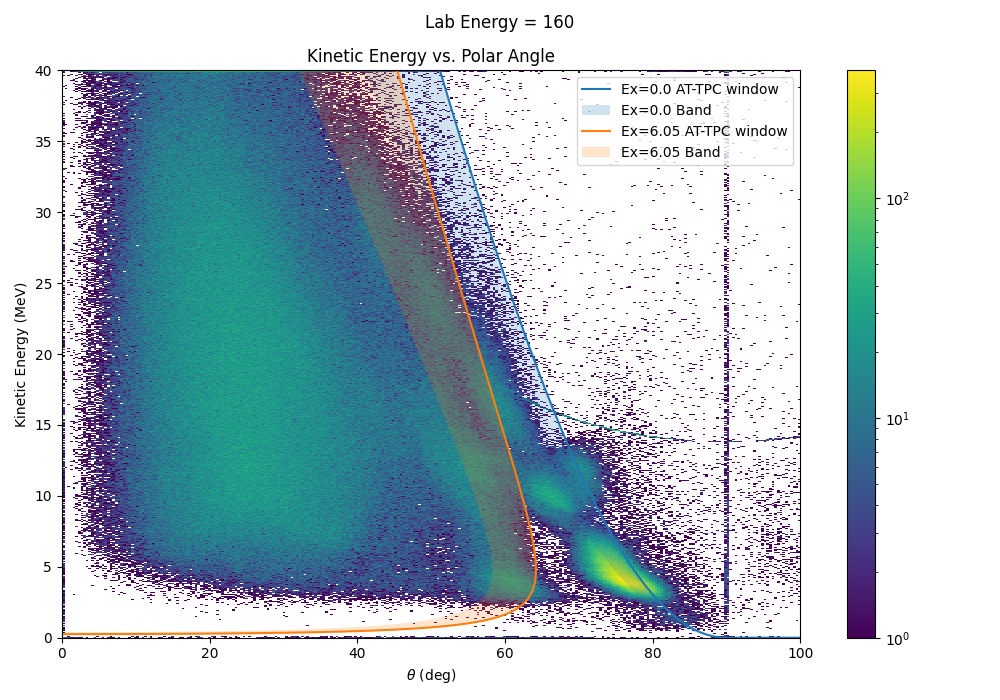

In [46]:
# Plot kinematics from data and compare with theoretical kinematics
grammer.add_hist2d('ke_theta', (500, 800), ((0.0, 180.0), (0.0, 40.0)))
grammer.fill_hist2d('ke_theta', np.rad2deg(results["polar"]), results["kinetic_energy"])
ke_theta = grammer.get_hist2d("ke_theta")

fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(ke_theta.x_bins, ke_theta.y_bins, ke_theta.counts, norm="log")
ax.set_title("Kinetic Energy vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Kinetic Energy (MeV)")
fig.colorbar(mesh, ax=ax)
for idx, ex in enumerate(residual_excitations):
    ax.plot(np.rad2deg(eject_kinematics[idx, :len(cm_angle_range), 0]), eject_kinematics[idx, :len(cm_angle_range), 1], label=f"Ex={ex:02} AT-TPC window")
    # Fill idea thanks to D. Ramirez
    ax.fill(np.rad2deg(eject_kinematics[idx, :, 0]), eject_kinematics[idx, :, 1], label=f"Ex={ex:02} Band", alpha=0.2)
ax.legend()
fig.set_figheight(7.0)
fig.set_figwidth(10.0)
plt.suptitle(f"Lab Energy = {proj_energy_start}")
plt.xlim(0,100)
plt.ylim(0,40)
fig.tight_layout()

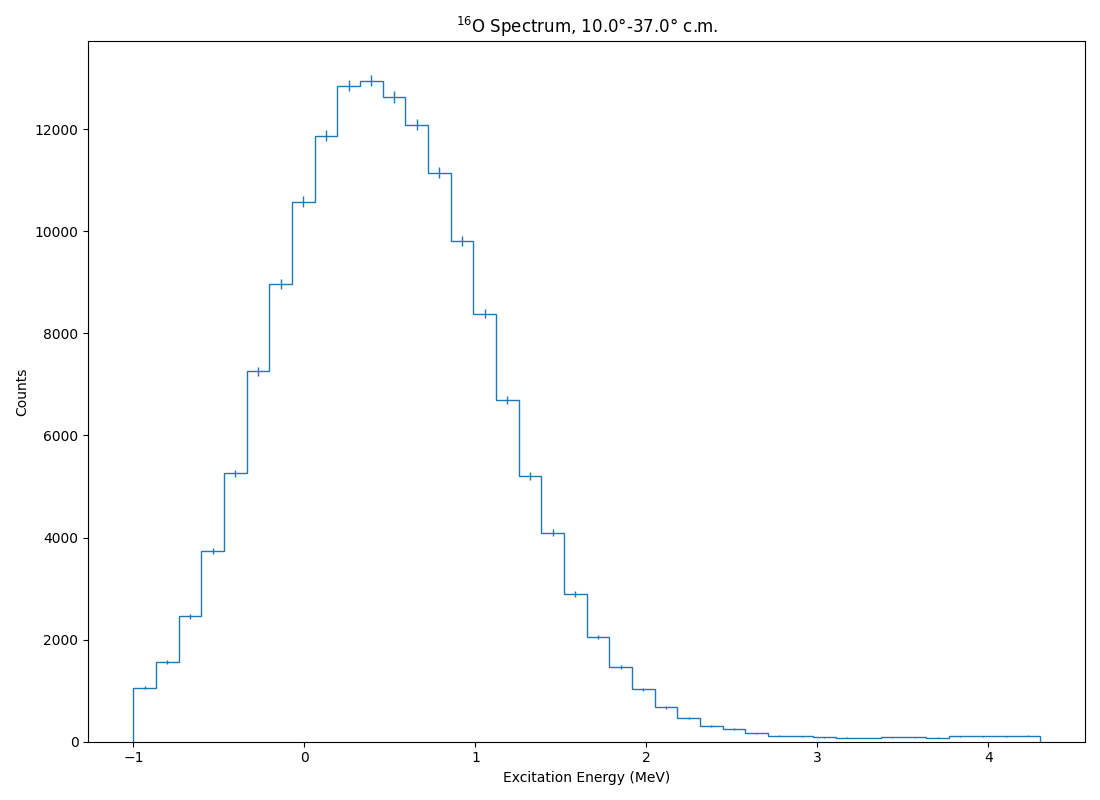

In [47]:
# Plot excitation energy spectrum

# Gate excitation spectrum on CM angle
mask_cm = (np.deg2rad(min_cm) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(max_cm))    # Make note of inequalites for binning!
ex_energy_gated = results["ex_energy"][mask_cm]

grammer.add_hist1d("ex_energy",hist_en_bins, (hist_en_min, hist_en_max))
grammer.fill_hist1d("ex_energy", ex_energy_gated)

ex_hist = grammer.get_hist1d("ex_energy")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins)
ax.errorbar(ex_hist.bins[:-1] + ex_hist.bin_width/2, ex_hist.counts, yerr=np.sqrt(ex_hist.counts), fmt="o", markersize=0, color="tab:blue", linewidth=1)
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

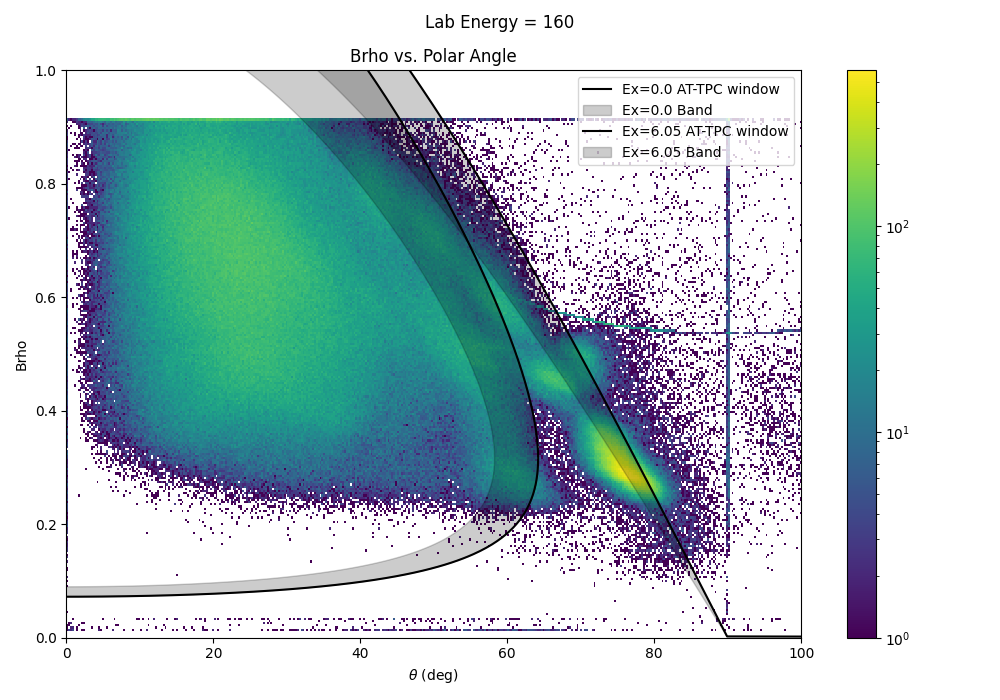

In [48]:
grammer.add_hist2d('brho_theta', (700, 800), ((0.0, 180.0), (-0.1, 3.0)))
grammer.fill_hist2d('brho_theta', np.rad2deg(results["polar"]), results["brho"])



brho_theta = grammer.get_hist2d("brho_theta")

fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(brho_theta.x_bins, brho_theta.y_bins, brho_theta.counts, norm="log")
for idx, ex in enumerate(residual_excitations):
    momentum_cm = np.sqrt((eject_kinematics[idx, :len(cm_angle_range), 1] + ejectile.mass)**2 - (ejectile.mass)**2)
    brho_cm = momentum_cm/(float(ejectile.Z) * QBRHO_2_P)

    momentum_dist = np.sqrt((eject_kinematics[idx, :, 1] + ejectile.mass)**2 - (ejectile.mass)**2)
    brho_dist = momentum_dist/(float(ejectile.Z) * QBRHO_2_P)

    ax.plot(np.rad2deg(eject_kinematics[idx, :len(cm_angle_range), 0]),brho_cm, label=f"Ex={ex:02} AT-TPC window", color="black")
    # Fill idea thanks to D. Ramirez
    ax.fill(np.rad2deg(eject_kinematics[idx, :, 0]), brho_dist, label=f"Ex={ex:02} Band", alpha=0.2,color="black")

ax.set_title("Brho vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Brho")
fig.colorbar(mesh, ax=ax)

ax.legend()
fig.set_figheight(7.0)
fig.set_figwidth(10.0)
plt.suptitle(f"Lab Energy = {proj_energy_start}")
plt.xlim(0,100)
plt.ylim(0,1)
fig.tight_layout()